**CHALLENGE OVERVIEW**

I try different techniques as suggested in the provided links:

1.   REDUCE MODEL SIZE
2.   PRUNING
3.   QUANTIZATION
4.   CLUSTERING
5.   DISTILLATION

**PHASE 1 - BASELINE** <br>
I run the baseline training (the model as it is delivered), to be able to optimize and compare it.

**PHASE 2 - REDUCE MODEL** <br>
I decrease the size of every layer in the model to reduce the number of parameters and make the model faster (most naive approach). <br>
n.b. I also try distillation to train a lighter model, but as I notice a better performance with the simple reduction I choose not to use Distillation.

**PHASE 3 - OPTIMIZATION** <br>
I experiment mentioned optimizations on given model by using them singularly or combining them. I then plot the results to find the best tradeoff among 3 criteria:


*   Accuracy
*   Time (Lower is better)
*   Model weight (Lower is better)

The reason is that I want to keep accuracy high while decreasing Time and Weight as much as possible as requested by the challange.

Using the Reduced model and applying Quantization and then Pruning seems the best solution.
This is because Redux operation hugely decreases model dimension. Also doing pruning as the last operations seems more beneficial, rather than using it before quantization.

I choose the rqp model and save it as .h5 file.

**PHASE 4 - COREML** <br>
The third request is to convert the model to a supported format, preferably CoreML.
I use the appropriate library to convert the model to a CoreML format to be easily used in an IOS environment.

**EXTRA** <br>
The "run_model.py" program is provided to classify a single image using the CoreML model in a MacOS environment. <br>
Command: <br>
python run_model.py --image *image_name* <br>
--image default option is 'fashion1.png'


In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
#Load the dataset.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
#Add a trailing unitary dimension to make a 3D multidimensional array (tensor).
# N x 28 x 28 --> N x 28 x 28 x 1
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [ ]:
#Convert the labels from integers to one-hot encoding.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000, 10)


In [ ]:
LR = 1E-3 
EPOCHS = 10
BATCH_SIZE = 64

In [ ]:
# Define baseline (and redux) models and train/test functions
def build_model(input_shape):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Activation('softmax'))

    return model

# Reduced model using halved dimensions
def build_model_reduced(input_shape):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Activation('softmax'))

    return model

def train(x_train, y_train, x_test, y_test, redux = False):
    """
    Train the model given the dataset and the global parameters (LR, EPOCHS and BATCH_SIZE).

    The model is automalically saved after the training.

    """
    if redux:
      model = build_model_reduced(x_train.shape[1:])
    else:
      model = build_model(x_train.shape[1:])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'],
    )
    print(model.summary())

    start_time = time.time()

    model.fit(
        x=x_train.astype(np.float32),
        y=y_train.astype(np.float32),
        epochs=EPOCHS,
        validation_data=(x_test.astype(np.float32), y_test.astype(np.float32)),
        batch_size=BATCH_SIZE,
    )

    end_time = time.time()
    print("Train elapsed time: {} seconds".format(end_time - start_time))

    if redux:
      model.save("fashion_mnist_model_redux.tf", overwrite=True)
    else:
      model.save("fashion_mnist_model.tf", overwrite=True)
    


def test(x_test, y_test, redux = False):
    """
    Load the saved model and evaluate it against the test set.
    """
    if redux:
      model = tf.keras.models.load_model("./fashion_mnist_model_redux.tf")
    else:
      model = tf.keras.models.load_model("./fashion_mnist_model.tf")

    print(model.summary())

    start_time = time.time()

    model.evaluate(x_test, y_test)

    end_time = time.time()
    print("Test elapsed time: {} seconds".format(end_time - start_time))


In [ ]:
# BASELINE
train(x_train, y_train, x_test, y_test)
test(x_test, y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0

In [ ]:
#model dimension
!du -h fashion_mnist_model.tf

4.0K	fashion_mnist_model.tf/assets
19M	fashion_mnist_model.tf/variables
19M	fashion_mnist_model.tf


In [ ]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 7.4MB/s 


**OPTIMIZATION FUNCTIONS DEFINITION**




In [ ]:
#1 PRUNING
import tensorflow_model_optimization as tfmot

def prune_model(model):
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Compute end step to finish pruning after 2 epochs.
  batch_size = 128
  epochs = 2
  validation_split = 0.1 # 10% of training set will be used for validation set. 

  num_images = x_train.shape[0] * (1 - validation_split)
  end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

  # Define model for pruning.
  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=0.80,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  model_for_pruning = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  print(model_for_pruning.summary())

  model_for_pruning.save("pruned_model.tf", overwrite=True)
  dimension = !du -h pruned_model.tf

  print(dimension)

  logdir = './'

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  model_for_pruning.fit(x_train, y_train,
                    batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                    callbacks=callbacks)
  
  start_time = time.time()

  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    x_test, y_test, verbose=0)

  end_time = time.time()

  prune_time = end_time - start_time 
  print("Test elapsed time: {} seconds".format(end_time - start_time)) 
  print('Pruned test accuracy:', model_for_pruning_accuracy)

  return model, [model_for_pruning_accuracy, prune_time, float(dimension[2].split('M')[0])]


In [ ]:
#2 QUANTIZATION

def apply_quantization_to_all(layer):
  if isinstance(layer, (#tf.keras.layers.Dense
                        #tf.keras.layers.Conv2D 
                        tf.keras.layers.MaxPooling2D, 
                        tf.keras.layers.Dropout
                        )):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

model = tf.keras.models.load_model("./fashion_mnist_model.tf")

annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization_to_all,
)

def quant_model(model):
  quantize_model = tfmot.quantization.keras.quantize_model

  # q_aware stands for for quantization aware.
  #q_aware_model = quantize_model(annotated_model)
  q_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

  # `quantize_model` requires a recompile.
  q_aware_model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  print(q_aware_model.summary())

  q_aware_model.save("quant_model.tf", overwrite=True)
  dimension = !du -h quant_model.tf 
  print(dimension)

  train_images_subset = x_train[0:1000] # out of 60000
  train_labels_subset = y_train[0:1000]

  q_aware_model.fit(train_images_subset, train_labels_subset,
                    batch_size=500, epochs=1, validation_split=0.1)
  
  start_time = time.time()

  _, q_aware_model_accuracy = q_aware_model.evaluate(
    x_test, y_test, verbose=0)

  end_time = time.time()
  quant_time = end_time - start_time
  print("Test elapsed time: {} seconds".format(end_time - start_time)) 
  print('Pruned test accuracy:', q_aware_model_accuracy)

  print(q_aware_model_accuracy, quant_time, dimension[2])

  return model, [q_aware_model_accuracy, quant_time, float(dimension[2].split('M')[0])]

In [ ]:
#3 Weight Clustering

def cluster_model(model):
  model = tf.keras.models.load_model("./fashion_mnist_model.tf")

  cluster_weights = tfmot.clustering.keras.cluster_weights
  CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

  clustering_params = {
    'number_of_clusters': 10,
    'cluster_centroids_init': CentroidInitialization.LINEAR
  }

  clustered_model = cluster_weights(model, **clustering_params)

  # Use smaller learning rate for fine-tuning clustered model
  opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

  clustered_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy'])

  print(clustered_model.summary())

  # Fine-tune model
  clustered_model.fit(
    x_train,
    y_train,
    batch_size=500,
    epochs=1,
    validation_split=0.1)
  
  start_time = time.time()

  _, clustered_model_accuracy = clustered_model.evaluate(
    x_test, y_test, verbose=0)

  end_time = time.time()

  clust_time = end_time - start_time 
  print("Test elapsed time: {} seconds".format(end_time - start_time)) 
  print('Clustered test accuracy:', clustered_model_accuracy)

  clustered_model.save("cluster_model.tf", overwrite=True)
  dimension = !du -h cluster_model.tf
  print(dimension)

  return model, [clustered_model_accuracy, clust_time, float(dimension[2].split('M')[0])]

In [ ]:
#4 Distillation

class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

# Create the student
def get_student(input_shape):
  student = tf.keras.models.Sequential()

  student.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
  student.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  student.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  student.add(tf.keras.layers.Dropout(0.25))

  student.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
  student.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
  student.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  student.add(tf.keras.layers.Dropout(0.25))

  student.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
  student.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
  student.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  student.add(tf.keras.layers.Dropout(0.25))

  student.add(tf.keras.layers.Flatten())
  student.add(tf.keras.layers.Dense(256))
  student.add(tf.keras.layers.Activation('elu'))
  student.add(tf.keras.layers.Dropout(0.5))
  student.add(tf.keras.layers.Dense(10))
  student.add(tf.keras.layers.Activation('softmax'))

  return student

def distill_model(model):
  teacher = model
  student = get_student(x_train.shape[1:])

  # Clone student for later comparison
  student_scratch = tf.keras.models.clone_model(student)

  # Initialize and compile distiller
  distiller = Distiller(student=student, teacher=teacher)
  distiller.compile(
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()],
      student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=tf.keras.losses.KLDivergence(),
      alpha=0.1,
      temperature=10,
  )

  print(x_train.shape, y_train.shape)
  # Distill teacher to student
  distiller.fit(x_train, y_train, epochs=10)

  # Evaluate student on test dataset
  distiller.evaluate(x_test, y_test)

  return distiller

In [ ]:
#Run Distillation t 10 ep 10
## n.b. here I notice poor performance and decide to drop it
model = tf.keras.models.load_model("./fashion_mnist_model.tf")
distilled_model = distill_model(model)

(60000, 28, 28, 1) (60000, 10)
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


1875/1875 [==============================] - 17s 8ms/step - categorical_accuracy: 0.7887 - student_loss: 0.6583 - distillation_loss: 1.1491e-04
Epoch 2/10
1875/1875 [==============================] - 16s 8ms/step - categorical_accuracy: 0.8573 - student_loss: 0.4088 - distillation_loss: 6.4139e-05
Epoch 3/10
1875/1875 [==============================] - 16s 8ms/step - categorical_accuracy: 0.8706 - student_loss: 0.3679 - distillation_loss: 5.4139e-05
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - categorical_accuracy: 0.8812 - student_loss: 0.3381 - distillation_loss: 4.8437e-05
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - categorical_accuracy: 0.8873 - student_loss: 0.3177 - distillation_loss: 4.4678e-05
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - categorical_accuracy: 0.8917 - student_loss: 0.3020 - distillation_loss: 4.2311e-05
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - categorica

In [ ]:
#Run Distillation
## n.b. here I notice poor performance and decide to drop it
distilled_model = distill_model(model)

(60000, 28, 28, 1) (60000, 10)
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


1875/1875 [==============================] - 17s 9ms/step - categorical_accuracy: 0.7860 - student_loss: 0.6622 - distillation_loss: 1.1683e-04
Epoch 2/10
1875/1875 [==============================] - 16s 9ms/step - categorical_accuracy: 0.8566 - student_loss: 0.4105 - distillation_loss: 6.3861e-05
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - categorical_accuracy: 0.8719 - student_loss: 0.3595 - distillation_loss: 5.2701e-05
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - categorical_accuracy: 0.8795 - student_loss: 0.3399 - distillation_loss: 4.8572e-05
Epoch 5/10
1875/1875 [==============================] - 16s 9ms/step - categorical_accuracy: 0.8846 - student_loss: 0.3248 - distillation_loss: 4.6136e-05
Epoch 6/10
1875/1875 [==============================] - 16s 9ms/step - categorical_accuracy: 0.8940 - student_loss: 0.3026 - distillation_loss: 4.1530e-05
Epoch 7/10
1875/1875 [==============================] - 16s 9ms/step - categorica

**PHASE 1 - BASELINE**

In [ ]:
# BASELINE
model = tf.keras.models.load_model("./fashion_mnist_model.tf")
start_time = time.time()

_, model_accuracy = model.evaluate(x_test, y_test)

end_time = time.time()

baseline_time = end_time - start_time 
print('Baseline test accuracy:', model_accuracy)
print("Test elapsed time: {} seconds".format(end_time - start_time))

baseline_dim = !du -h fashion_mnist_model.tf
baseline_dim = float(baseline_dim[2].split('M')[0])


313/313 [==============================] - 1s 4ms/step - loss: 0.2585 - categorical_accuracy: 0.9108
Baseline test accuracy: 0.9107999801635742
Test elapsed time: 1.434041976928711 seconds


**PHASE 2 - REDUCE MODEL**

In [ ]:
# REDUX (model with reduced dimensions)
train(x_train, y_train, x_test, y_test, redux = True)
#test(x_test, y_test, redux = True)

model = tf.keras.models.load_model("./fashion_mnist_model_redux.tf")
start_time = time.time()

_, redux_accuracy = model.evaluate(x_test, y_test)

end_time = time.time()

redux_time = end_time - start_time 
print('Redux test accuracy:', model_accuracy)
print("Test elapsed time: {} seconds".format(end_time - start_time))

redux_dim = !du -h fashion_mnist_model_redux.tf
redux_dim = float(redux_dim[2].split('M')[0])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_9 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)         

**PHASE 3 - OPTIMIZATION**

In [ ]:
#PRUNING

model = tf.keras.models.load_model("./fashion_mnist_model.tf")

pruned_model, pruned_results = prune_model(model)

prune_dim = !du -h pruned_model.tf
prune_dim = float(prune_dim[2].split('M')[0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 28, 28, 1)         5         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 28, 28, 64)        3266      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 64)        1         
_________________________________________________________________
prune_low_magnitude_dropout  (None, 14, 14, 64)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 14, 14, 64)        257       
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 14, 14, 128)       409730    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 7, 7, 128)         1

INFO:tensorflow:Assets written to: pruned_model.tf/assets


INFO:tensorflow:Assets written to: pruned_model.tf/assets


['4.0K\tpruned_model.tf/assets', '13M\tpruned_model.tf/variables', '15M\tpruned_model.tf']
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


  5/422 [..............................] - ETA: 1:13 - loss: 0.1915 - accuracy: 0.9266WARNING:tensorflow:Callback method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_begin` time: 0.0526s). Check your callbacks.


422/422 [==============================] - 16s 31ms/step - loss: 0.2162 - accuracy: 0.9198 - val_loss: 0.1648 - val_accuracy: 0.9395
Epoch 2/2
422/422 [==============================] - 12s 28ms/step - loss: 0.2241 - accuracy: 0.9200 - val_loss: 0.1593 - val_accuracy: 0.9385
Test elapsed time: 0.9480061531066895 seconds
Pruned test accuracy: 0.9146000146865845


In [ ]:
#QUANTIZATION

model = tf.keras.models.load_model("./fashion_mnist_model.tf")
quantized_model, quantized_results = quant_model(model)

quant_dim = !du -h quant_model.tf
quant_dim = float(quant_dim[2].split('M')[0])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 14, 14, 64)        1         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 7, 7, 128)         1

INFO:tensorflow:Assets written to: quant_model.tf/assets


INFO:tensorflow:Assets written to: quant_model.tf/assets


['4.0K\tquant_model.tf/assets', '6.2M\tquant_model.tf/variables', '6.7M\tquant_model.tf']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2/2 [==============================] - 3s 1s/step - loss: 0.1603 - accuracy: 0.9422 - val_loss: 0.1530 - val_accuracy: 0.9300
Test elapsed time: 0.9212069511413574 seconds
Pruned test accuracy: 0.910099983215332
0.910099983215332 0.9212069511413574 6.7M	quant_model.tf


In [ ]:
#CLUSTER

model = tf.keras.models.load_model("./fashion_mnist_model.tf")
clusterd_model, clustered_results = cluster_model(model)

clust_dim = !du -h cluster_model.tf
clust_dim = float(clust_dim[2].split('M')[0])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_batch_normalization  (None, 28, 28, 1)         4         
_________________________________________________________________
cluster_conv2d (ClusterWeigh (None, 28, 28, 64)        1674      
_________________________________________________________________
cluster_max_pooling2d (Clust (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_dropout (ClusterWeig (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_batch_normalization_ (None, 14, 14, 64)        256       
_________________________________________________________________
cluster_conv2d_1 (ClusterWei (None, 14, 14, 128)       204938    
_________________________________________________________________
cluster_max_pooling2d_1 (Clu (None, 7, 7, 128)         0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


108/108 [==============================] - 8s 64ms/step - loss: 0.1568 - accuracy: 0.9378 - val_loss: 0.1498 - val_accuracy: 0.9378
Test elapsed time: 1.6574249267578125 seconds
Clustered test accuracy: 0.9059000015258789


INFO:tensorflow:Assets written to: cluster_model.tf/assets


INFO:tensorflow:Assets written to: cluster_model.tf/assets


['4.0K\tcluster_model.tf/assets', '13M\tcluster_model.tf/variables', '13M\tcluster_model.tf']


**COMBINATION OF OPTIMIZATIONS**

In [ ]:
#OPTIMIZATIONS ON BASELINE

#QUANT + PRUNE
model = tf.keras.models.load_model("./fashion_mnist_model.tf")
qp_model, qp_results = quant_model(model)
qp_model, qp_results = prune_model(qp_model)

#PRUNE + QUANT
model = tf.keras.models.load_model("./fashion_mnist_model.tf")
pq_model, pq_results = prune_model(model)
pq_model, pq_results = quant_model(pq_model)

#QUANT + CLUST
model = tf.keras.models.load_model("./fashion_mnist_model.tf")
qc_model, qc_results = quant_model(model)
qc_model, qc_results = cluster_model(qc_model)

#CLUST + QUANT
model = tf.keras.models.load_model("./fashion_mnist_model.tf")
cq_model, cq_results = cluster_model(model)
cq_model, cq_results = quant_model(cq_model)

#PRUNE + CLUST
model = tf.keras.models.load_model("./fashion_mnist_model.tf")
pc_model, pc_results = prune_model(model)
pc_model, pc_results = cluster_model(pc_model)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 14, 14, 64)        1         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 7, 7, 128)         1

INFO:tensorflow:Assets written to: quant_model.tf/assets


INFO:tensorflow:Assets written to: quant_model.tf/assets


['4.0K\tquant_model.tf/assets', '6.2M\tquant_model.tf/variables', '6.7M\tquant_model.tf']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2/2 [==============================] - 1s 270ms/step - loss: 0.1567 - accuracy: 0.9411 - val_loss: 0.1661 - val_accuracy: 0.9200
Test elapsed time: 1.304358959197998 seconds
Pruned test accuracy: 0.9168000221252441
0.9168000221252441 1.304358959197998 6.7M	quant_model.tf
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 28, 28, 1)         5         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 28, 28, 64)        3266      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 64)        1         
_________________________________________________________________
prune_low_magnitude_dropout  (None, 14, 14, 64)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 14, 14, 64) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Assets written to: pruned_model.tf/assets


INFO:tensorflow:Assets written to: pruned_model.tf/assets


['4.0K\tpruned_model.tf/assets', '13M\tpruned_model.tf/variables', '15M\tpruned_model.tf']
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


  5/422 [..............................] - ETA: 1:55 - loss: 0.1911 - accuracy: 0.9219WARNING:tensorflow:Callback method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_begin` time: 0.0510s). Check your callbacks.


422/422 [==============================] - 16s 31ms/step - loss: 0.2214 - accuracy: 0.9189 - val_loss: 0.1785 - val_accuracy: 0.9315
Epoch 2/2
422/422 [==============================] - 12s 28ms/step - loss: 0.2250 - accuracy: 0.9195 - val_loss: 0.1712 - val_accuracy: 0.9338
Test elapsed time: 0.9943017959594727 seconds
Pruned test accuracy: 0.9121999740600586


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 28, 28, 1)         5         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 28, 28, 64)        3266      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 64)        1         
_________________________________________________________________
prune_low_magnitude_dropout  (None, 14, 14, 64)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 14, 14, 64)        257       
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 14, 14, 128)       409730    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 7, 7, 128)         1

INFO:tensorflow:Assets written to: pruned_model.tf/assets


INFO:tensorflow:Assets written to: pruned_model.tf/assets


['4.0K\tpruned_model.tf/assets', '13M\tpruned_model.tf/variables', '15M\tpruned_model.tf']
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


  5/422 [..............................] - ETA: 1:34 - loss: 0.1882 - accuracy: 0.9250WARNING:tensorflow:Callback method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0167s vs `on_train_batch_begin` time: 0.0492s). Check your callbacks.


422/422 [==============================] - 16s 30ms/step - loss: 0.2235 - accuracy: 0.9188 - val_loss: 0.1743 - val_accuracy: 0.9343
Epoch 2/2
422/422 [==============================] - 12s 28ms/step - loss: 0.2259 - accuracy: 0.9173 - val_loss: 0.1603 - val_accuracy: 0.9362
Test elapsed time: 0.9123210906982422 seconds
Pruned test accuracy: 0.9187999963760376
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 14, 14, 64)        1         
_______________________

INFO:tensorflow:Assets written to: quant_model.tf/assets


INFO:tensorflow:Assets written to: quant_model.tf/assets


['4.0K\tquant_model.tf/assets', '6.2M\tquant_model.tf/variables', '6.7M\tquant_model.tf']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2/2 [==============================] - 1s 272ms/step - loss: 0.1591 - accuracy: 0.9478 - val_loss: 0.1592 - val_accuracy: 0.9300
Test elapsed time: 1.3078632354736328 seconds
Pruned test accuracy: 0.9171000123023987
0.9171000123023987 1.3078632354736328 6.7M	quant_model.tf
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 14, 14, 64)        1         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64

INFO:tensorflow:Assets written to: quant_model.tf/assets


INFO:tensorflow:Assets written to: quant_model.tf/assets


['4.0K\tquant_model.tf/assets', '6.2M\tquant_model.tf/variables', '6.7M\tquant_model.tf']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2/2 [==============================] - 1s 269ms/step - loss: 0.1680 - accuracy: 0.9344 - val_loss: 0.1511 - val_accuracy: 0.9200
Test elapsed time: 1.3012745380401611 seconds
Pruned test accuracy: 0.9160000085830688
0.9160000085830688 1.3012745380401611 6.7M	quant_model.tf
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_batch_normalization  (None, 28, 28, 1)         4         
_________________________________________________________________
cluster_conv2d (ClusterWeigh (None, 28, 28, 64)        1674      
_________________________________________________________________
cluster_max_pooling2d (Clust (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_dropout (ClusterWeig (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_batch_normalization_ (None, 14, 14, 64

INFO:tensorflow:Assets written to: cluster_model.tf/assets


INFO:tensorflow:Assets written to: cluster_model.tf/assets


['4.0K\tcluster_model.tf/assets', '13M\tcluster_model.tf/variables', '13M\tcluster_model.tf']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_batch_normalization  (None, 28, 28, 1)         4         
_________________________________________________________________
cluster_conv2d (ClusterWeigh (None, 28, 28, 64)        1674      
_________________________________________________________________
cluster_max_pooling2d (Clust (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_dropout (ClusterWeig (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_batch_normalization_ (None, 14, 14, 64)        256       
_________________________________________________________________
cluster_conv2d_1 (ClusterWei (None, 14, 14, 128)       204938    
____________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


108/108 [==============================] - 8s 63ms/step - loss: 0.1567 - accuracy: 0.9381 - val_loss: 0.1496 - val_accuracy: 0.9382
Test elapsed time: 3.1891367435455322 seconds
Clustered test accuracy: 0.9059000015258789


INFO:tensorflow:Assets written to: cluster_model.tf/assets


INFO:tensorflow:Assets written to: cluster_model.tf/assets


['4.0K\tcluster_model.tf/assets', '13M\tcluster_model.tf/variables', '13M\tcluster_model.tf']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 14, 14, 64)        1         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
____________________________

INFO:tensorflow:Assets written to: quant_model.tf/assets


INFO:tensorflow:Assets written to: quant_model.tf/assets


['4.0K\tquant_model.tf/assets', '6.2M\tquant_model.tf/variables', '6.7M\tquant_model.tf']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2/2 [==============================] - 1s 264ms/step - loss: 0.1616 - accuracy: 0.9378 - val_loss: 0.1629 - val_accuracy: 0.9500
Test elapsed time: 0.9545917510986328 seconds
Pruned test accuracy: 0.9182999730110168
0.9182999730110168 0.9545917510986328 6.7M	quant_model.tf


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 28, 28, 1)         5         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 28, 28, 64)        3266      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 64)        1         
_________________________________________________________________
prune_low_magnitude_dropout  (None, 14, 14, 64)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 14, 14, 64)        257       
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 14, 14, 128)       409730    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 7, 7, 128)         1

INFO:tensorflow:Assets written to: pruned_model.tf/assets


INFO:tensorflow:Assets written to: pruned_model.tf/assets


['4.0K\tpruned_model.tf/assets', '13M\tpruned_model.tf/variables', '15M\tpruned_model.tf']
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


  5/422 [..............................] - ETA: 2:12 - loss: 0.2264 - accuracy: 0.9094WARNING:tensorflow:Callback method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0167s vs `on_train_batch_begin` time: 0.0506s). Check your callbacks.


422/422 [==============================] - 16s 31ms/step - loss: 0.2163 - accuracy: 0.9202 - val_loss: 0.1741 - val_accuracy: 0.9293
Epoch 2/2
422/422 [==============================] - 12s 28ms/step - loss: 0.2222 - accuracy: 0.9196 - val_loss: 0.1535 - val_accuracy: 0.9410
Test elapsed time: 0.9208343029022217 seconds
Pruned test accuracy: 0.9193999767303467
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_batch_normalization  (None, 28, 28, 1)         4         
_________________________________________________________________
cluster_conv2d (ClusterWeigh (None, 28, 28, 64)        1674      
_________________________________________________________________
cluster_max_pooling2d (Clust (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_dropout (ClusterWeig (None, 14, 14, 64)        0         
_______________________

INFO:tensorflow:Assets written to: cluster_model.tf/assets


INFO:tensorflow:Assets written to: cluster_model.tf/assets


['4.0K\tcluster_model.tf/assets', '13M\tcluster_model.tf/variables', '13M\tcluster_model.tf']


In [ ]:
## OPTIMIZATIONS ON REDUX

#QUANT + PRUNE
model = tf.keras.models.load_model("./fashion_mnist_model_redux.tf")
rqp_model, rqp_results = quant_model(model)
rqp_model, rqp_results = prune_model(rqp_model)

#PRUNE + QUANT
model = tf.keras.models.load_model("./fashion_mnist_model_redux.tf")
rpq_model, rpq_results = prune_model(model)
rpq_model, rpq_results = quant_model(rpq_model)

#QUANT + CLUST
model = tf.keras.models.load_model("./fashion_mnist_model_redux.tf")
rqc_model, rqc_results = quant_model(model)
rqc_model, rqc_results = cluster_model(rqc_model)

#CLUST + QUANT
model = tf.keras.models.load_model("./fashion_mnist_model_redux.tf")
rcq_model, rcq_results = cluster_model(model)
rcq_model, rcq_results = quant_model(rcq_model)

#PRUNE + CLUST
model = tf.keras.models.load_model("./fashion_mnist_model_redux.tf")
rpc_model, rpc_results = prune_model(model)
rpc_model, rpc_results = cluster_model(rpc_model)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 14, 14, 64)        1         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 7, 7, 128)         1

['4.0K\tquant_model.tf/assets', '6.2M\tquant_model.tf/variables', '6.7M\tquant_model.tf']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2/2 [==============================] - 1s 270ms/step - loss: 0.1787 - accuracy: 0.9322 - val_loss: 0.1501 - val_accuracy: 0.9200
Test elapsed time: 1.2998781204223633 seconds
Pruned test accuracy: 0.9154000282287598
0.9154000282287598 1.2998781204223633 6.7M	quant_model.tf
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 28, 28, 1)         5         
_________________________________________________________________
prune_low_magnitude_conv2d_9 (None, 28, 28, 32)        1634      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 32)        1         
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 14, 14, 32)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 14, 14, 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


['4.0K\tpruned_model.tf/assets', '3.2M\tpruned_model.tf/variables', '5.0M\tpruned_model.tf']
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


422/422 [==============================] - 13s 23ms/step - loss: 0.2663 - accuracy: 0.9030 - val_loss: 0.2099 - val_accuracy: 0.9215
Epoch 2/2
422/422 [==============================] - 8s 19ms/step - loss: 0.2879 - accuracy: 0.8991 - val_loss: 0.1909 - val_accuracy: 0.9290
Test elapsed time: 0.6957435607910156 seconds
Pruned test accuracy: 0.9099000096321106


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 28, 28, 1)         5         
_________________________________________________________________
prune_low_magnitude_conv2d_9 (None, 28, 28, 32)        1634      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 32)        1         
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 14, 14, 32)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 14, 14, 32)        129       
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 14, 14, 64)        102466    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 7, 7, 64)         

['4.0K\tpruned_model.tf/assets', '3.2M\tpruned_model.tf/variables', '5.0M\tpruned_model.tf']
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


422/422 [==============================] - 14s 23ms/step - loss: 0.2624 - accuracy: 0.9034 - val_loss: 0.2091 - val_accuracy: 0.9227
Epoch 2/2
422/422 [==============================] - 8s 19ms/step - loss: 0.2803 - accuracy: 0.9010 - val_loss: 0.1905 - val_accuracy: 0.9320
Test elapsed time: 1.3004262447357178 seconds
Pruned test accuracy: 0.9100000262260437
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 14, 14, 64)        1         
________________________

['4.0K\tquant_model.tf/assets', '6.2M\tquant_model.tf/variables', '6.7M\tquant_model.tf']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2/2 [==============================] - 1s 263ms/step - loss: 0.1610 - accuracy: 0.9400 - val_loss: 0.1621 - val_accuracy: 0.9300
Test elapsed time: 1.3012731075286865 seconds
Pruned test accuracy: 0.9139000177383423
0.9139000177383423 1.3012731075286865 6.7M	quant_model.tf
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 14, 14, 64)        1         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64

['4.0K\tquant_model.tf/assets', '6.2M\tquant_model.tf/variables', '6.7M\tquant_model.tf']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2/2 [==============================] - 1s 259ms/step - loss: 0.1703 - accuracy: 0.9411 - val_loss: 0.1607 - val_accuracy: 0.9000
Test elapsed time: 1.3007524013519287 seconds
Pruned test accuracy: 0.9096999764442444
0.9096999764442444 1.3007524013519287 6.7M	quant_model.tf
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_batch_normalization  (None, 28, 28, 1)         4         
_________________________________________________________________
cluster_conv2d (ClusterWeigh (None, 28, 28, 64)        1674      
_________________________________________________________________
cluster_max_pooling2d (Clust (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_dropout (ClusterWeig (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_batch_normalization_ (None, 14, 14, 64

['4.0K\tcluster_model.tf/assets', '13M\tcluster_model.tf/variables', '13M\tcluster_model.tf']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_batch_normalization  (None, 28, 28, 1)         4         
_________________________________________________________________
cluster_conv2d (ClusterWeigh (None, 28, 28, 64)        1674      
_________________________________________________________________
cluster_max_pooling2d (Clust (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_dropout (ClusterWeig (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_batch_normalization_ (None, 14, 14, 64)        256       
_________________________________________________________________
cluster_conv2d_1 (ClusterWei (None, 14, 14, 128)       204938    
____________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


108/108 [==============================] - 7s 60ms/step - loss: 0.1566 - accuracy: 0.9377 - val_loss: 0.1498 - val_accuracy: 0.9382
Test elapsed time: 2.7570245265960693 seconds
Clustered test accuracy: 0.9060999751091003


['4.0K\tcluster_model.tf/assets', '13M\tcluster_model.tf/variables', '13M\tcluster_model.tf']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 14, 14, 64)        1         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
____________________________

['4.0K\tquant_model.tf/assets', '6.2M\tquant_model.tf/variables', '6.7M\tquant_model.tf']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2/2 [==============================] - 1s 259ms/step - loss: 0.1774 - accuracy: 0.9344 - val_loss: 0.1509 - val_accuracy: 0.9300
Test elapsed time: 1.3011274337768555 seconds
Pruned test accuracy: 0.9143000245094299
0.9143000245094299 1.3011274337768555 6.7M	quant_model.tf


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 28, 28, 1)         5         
_________________________________________________________________
prune_low_magnitude_conv2d_9 (None, 28, 28, 32)        1634      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 32)        1         
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 14, 14, 32)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 14, 14, 32)        129       
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 14, 14, 64)        102466    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 7, 7, 64)         

['4.0K\tpruned_model.tf/assets', '3.2M\tpruned_model.tf/variables', '5.0M\tpruned_model.tf']
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


422/422 [==============================] - 14s 24ms/step - loss: 0.2647 - accuracy: 0.9039 - val_loss: 0.2066 - val_accuracy: 0.9222
Epoch 2/2
422/422 [==============================] - 8s 20ms/step - loss: 0.2782 - accuracy: 0.9004 - val_loss: 0.1896 - val_accuracy: 0.9298
Test elapsed time: 1.2994587421417236 seconds
Pruned test accuracy: 0.9103999733924866
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_batch_normalization  (None, 28, 28, 1)         4         
_________________________________________________________________
cluster_conv2d (ClusterWeigh (None, 28, 28, 64)        1674      
_________________________________________________________________
cluster_max_pooling2d (Clust (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_dropout (ClusterWeig (None, 14, 14, 64)        0         
________________________

['4.0K\tcluster_model.tf/assets', '13M\tcluster_model.tf/variables', '13M\tcluster_model.tf']


In [ ]:
# All OPT

# q + p + c
model = tf.keras.models.load_model("./fashion_mnist_model.tf")
qpc_model, qpc_results = quant_model(model)
qpc_model, qpc_results = prune_model(qpc_model)
qpc_model, qpc_results = cluster_model(qpc_model)

# r + q + p + c
model = tf.keras.models.load_model("./fashion_mnist_model_redux.tf")
rqpc_model, rqpc_results = quant_model(model)
rqpc_model, rqpc_results = prune_model(rqpc_model)
rqpc_model, rqpc_results = cluster_model(rqpc_model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 14, 14, 64)        1         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 7, 7, 128)         1

INFO:tensorflow:Assets written to: quant_model.tf/assets


INFO:tensorflow:Assets written to: quant_model.tf/assets


['4.0K\tquant_model.tf/assets', '6.2M\tquant_model.tf/variables', '6.7M\tquant_model.tf']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2/2 [==============================] - 1s 259ms/step - loss: 0.1656 - accuracy: 0.9389 - val_loss: 0.1657 - val_accuracy: 0.9500
Test elapsed time: 1.3017518520355225 seconds
Pruned test accuracy: 0.9172999858856201
0.9172999858856201 1.3017518520355225 6.7M	quant_model.tf
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 28, 28, 1)         5         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 28, 28, 64)        3266      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 64)        1         
_________________________________________________________________
prune_low_magnitude_dropout  (None, 14, 14, 64)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 14, 14, 64

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Assets written to: pruned_model.tf/assets


INFO:tensorflow:Assets written to: pruned_model.tf/assets


['4.0K\tpruned_model.tf/assets', '13M\tpruned_model.tf/variables', '15M\tpruned_model.tf']
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


  5/422 [..............................] - ETA: 1:51 - loss: 0.2350 - accuracy: 0.9141WARNING:tensorflow:Callback method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_begin` time: 0.0512s). Check your callbacks.


422/422 [==============================] - 16s 30ms/step - loss: 0.2176 - accuracy: 0.9206 - val_loss: 0.1766 - val_accuracy: 0.9330
Epoch 2/2
422/422 [==============================] - 11s 27ms/step - loss: 0.2215 - accuracy: 0.9200 - val_loss: 0.1540 - val_accuracy: 0.9410
Test elapsed time: 1.0054974555969238 seconds
Pruned test accuracy: 0.917900025844574
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_batch_normalization  (None, 28, 28, 1)         4         
_________________________________________________________________
cluster_conv2d (ClusterWeigh (None, 28, 28, 64)        1674      
_________________________________________________________________
cluster_max_pooling2d (Clust (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_dropout (ClusterWeig (None, 14, 14, 64)        0         
________________________

INFO:tensorflow:Assets written to: cluster_model.tf/assets


INFO:tensorflow:Assets written to: cluster_model.tf/assets


['4.0K\tcluster_model.tf/assets', '13M\tcluster_model.tf/variables', '13M\tcluster_model.tf']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 14, 14, 64)        1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 14, 14, 64)        1         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
____________________________

INFO:tensorflow:Assets written to: quant_model.tf/assets


INFO:tensorflow:Assets written to: quant_model.tf/assets


['4.0K\tquant_model.tf/assets', '6.2M\tquant_model.tf/variables', '6.7M\tquant_model.tf']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2/2 [==============================] - 1s 275ms/step - loss: 0.1698 - accuracy: 0.9333 - val_loss: 0.1691 - val_accuracy: 0.9500
Test elapsed time: 1.298142671585083 seconds
Pruned test accuracy: 0.9172999858856201
0.9172999858856201 1.298142671585083 6.7M	quant_model.tf
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 28, 28, 1)         5         
_________________________________________________________________
prune_low_magnitude_conv2d_9 (None, 28, 28, 32)        1634      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 14, 14, 32)        1         
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 14, 14, 32)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 14, 14, 32

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Assets written to: pruned_model.tf/assets


INFO:tensorflow:Assets written to: pruned_model.tf/assets


['4.0K\tpruned_model.tf/assets', '3.2M\tpruned_model.tf/variables', '5.0M\tpruned_model.tf']
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


  5/422 [..............................] - ETA: 1:47 - loss: 0.2517 - accuracy: 0.8969WARNING:tensorflow:Callback method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0115s vs `on_train_batch_begin` time: 0.0528s). Check your callbacks.


422/422 [==============================] - 14s 23ms/step - loss: 0.2593 - accuracy: 0.9053 - val_loss: 0.2091 - val_accuracy: 0.9200
Epoch 2/2
422/422 [==============================] - 8s 19ms/step - loss: 0.2805 - accuracy: 0.8999 - val_loss: 0.1924 - val_accuracy: 0.9290
Test elapsed time: 1.3016774654388428 seconds
Pruned test accuracy: 0.9053999781608582
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_batch_normalization  (None, 28, 28, 1)         4         
_________________________________________________________________
cluster_conv2d (ClusterWeigh (None, 28, 28, 64)        1674      
_________________________________________________________________
cluster_max_pooling2d (Clust (None, 14, 14, 64)        0         
_________________________________________________________________
cluster_dropout (ClusterWeig (None, 14, 14, 64)        0         
________________________

INFO:tensorflow:Assets written to: cluster_model.tf/assets


INFO:tensorflow:Assets written to: cluster_model.tf/assets


['4.0K\tcluster_model.tf/assets', '13M\tcluster_model.tf/variables', '13M\tcluster_model.tf']


In [ ]:
# b -> baseline
# r -> redux
# p -> pruning
# q -> quantization
# c -> clustering

models = ['b', 'r', 'p', 'q', 'c', 'qp', 'pq', 'qc', 'cq', 'pc', 'rqp', 'rpq', 'rqc', 'rcq', 'rpc', 'qpc', 'rqpc']
scores = [model_accuracy, 
          redux_accuracy,
          pruned_results[0], 
          quantized_results[0], 
          clustered_results[0], 
          qp_results[0],
          pq_results[0],
          qc_results[0],
          cq_results[0],
          pc_results[0],
          rqp_results[0],
          rpq_results[0],
          rqc_results[0],
          rcq_results[0],
          rpc_results[0],
          qpc_results[0],
          rqpc_results[0]]
times = [baseline_time,
         redux_time,
         pruned_results[1], 
         quantized_results[1],
         clustered_results[1], 
         qp_results[1],
          pq_results[1],
          qc_results[1],
          cq_results[1],
          pc_results[1],
         rqp_results[1],
          rpq_results[1],
          rqc_results[1],
          rcq_results[1],
          rpc_results[1],
          qpc_results[1],
          rqpc_results[1]]
dimensions = [baseline_dim, 
              redux_dim,
              pruned_results[2], 
              quantized_results[2], 
              clustered_results[2], 
              qp_results[2],
              pq_results[2],
              qc_results[2],
              cq_results[2],
              pc_results[2],
              rqp_results[2],
              rpq_results[2],
              rqc_results[2],
              rcq_results[2],
              rpc_results[2],
              qpc_results[2],
              rqpc_results[2]]

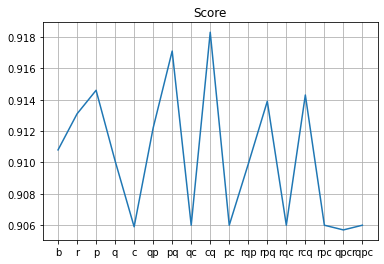

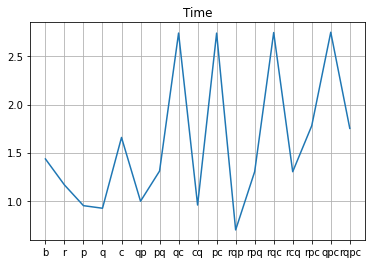

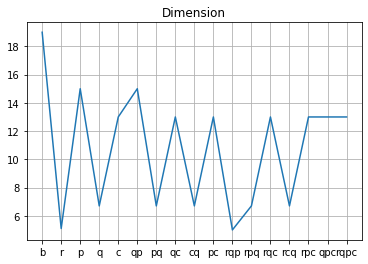

In [ ]:
#Plot all configurations for tradeoff

import matplotlib.pyplot as plt

plt.figure()
plt.title('Score')
plt.plot(models, scores)
plt.grid()
plt.show()

plt.figure()
plt.title('Time')
plt.plot(models, times)
plt.grid()
plt.show()

plt.figure()
plt.title('Dimension')
plt.plot(models, dimensions)
plt.grid()
plt.show()

In [ ]:
# Percentage gain in performance with respect to baseline
def get_perc_gain(final_results):
  base_acc = scores[0]
  base_time = times[0]
  base_dim = dimensions[0]

  perc_acc_gain = -100 * (1 - final_results[0] / base_acc)
  perc_time_gain = -100 * (1 - final_results[1] / base_time)
  perc_dim_gain = -100 * (1 - final_results[2] / base_dim)

  '''
  print('Opt model accuracy: ' + str(final_results[0]))
  print('Baseline accuracy: ' + str(base_acc))
  print('Opt model time: ' + str(final_results[1]))
  print('Baseline time: ' + str(base_time))
  print('Opt model dimension: ' + str(final_results[2]))
  print('Baseline dimension: ' + str(base_dim))
  print('\n')
  '''

  print('Accuracy gain flat: ' + str(round(final_results[0] - base_acc, 3)) + ' %' )
  print('Accuracy gain percentage: ' + str(round(perc_acc_gain, 2)) + ' %' )

  print('Time gain flat: ' + str(round(final_results[1] - base_time, 2)) + ' s' )
  print('Time gain percentage: ' + str(round(perc_time_gain, 2)) + ' %')

  print('Dimension gain flat: ' + str(final_results[2] - base_dim) + ' Mb' )
  print('Dimension gain percentage: ' + str(round(perc_dim_gain, 2)) + ' %')
  print('\n')

print('rqp model')
get_perc_gain(rqp_results)
print('rpq model')
get_perc_gain(rpq_results)
print('q model')
get_perc_gain(quantized_results)


rqp model
Accuracy gain flat: -0.001 %
Accuracy gain percentage: -0.1 %
Time gain flat: -0.74 s
Time gain percentage: -51.48 %
Dimension gain flat: -14.0 Mb
Dimension gain percentage: -73.68 %


rpq model
Accuracy gain flat: 0.003 %
Accuracy gain percentage: 0.34 %
Time gain flat: -0.13 s
Time gain percentage: -9.26 %
Dimension gain flat: -12.3 Mb
Dimension gain percentage: -64.74 %


q model
Accuracy gain flat: -0.001 %
Accuracy gain percentage: -0.08 %
Time gain flat: -0.51 s
Time gain percentage: -35.76 %
Dimension gain flat: -12.3 Mb
Dimension gain percentage: -64.74 %




In [62]:
# number of params gain
model = tf.keras.models.load_model("./fashion_mnist_model.tf") 
param_gain = rqp_model.count_params() - model.count_params()
perc_param_gain = str(round(-100 * (1 - rqp_model.count_params() / model.count_params()), 2))

print('Number of parameters flat gain: ' + str(param_gain))
print('Number of parameters perc gain: ' + str(perc_param_gain) + '%')

Number of parameters flat gain: -1213184
Number of parameters perc gain: -74.91%


**CHOICE** <br>
The best solutions are:
- q: we drop it because it does not reduce the number of parameters
- rqp: best performance for Time and Dim but Accuracy is (slightly) lower than rpq
- rpq: less efficient in terms of Time and Dim when compared to rqp but higher Accuracy

We choose **rqp** model as it has the overall best performance in Time and Dimension while having a relatively small amount of accuracy loss(<0.01%) when compared to rpq. We choose to give more emphasis to the Time parameter as we run the model on a mobile.

The final (optimized) model performace when compared to baseline (for percentages look at previous cells):
- Accuracy gain flat: -0.001 %
- Time gain flat: -0.51 s
- Dimension gain flat: -12.3 Mb
- Parameter number gain flat:  -1,213,184

In [ ]:
# Save the chosen model - rqp
rqp_model.save('final_model.tf')
final_model = tf.keras.models.load_model("./final_model.tf")
final_model.save('final_model.h5')

In [ ]:
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_9 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)         

In [ ]:
#Plot the tradeoff as percentage gain when compared to baseline
'''
base_acc = scores[0]
base_time = times[0]
base_dim = dimensions[0]
for i, v in enumerate(scores):
  scores[i] = 1 - float(scores[i]/base_acc)
  times[i] = 1 - float(times[i]/base_time)
  dimensions[i] = 1 - float(dimensions[i]/base_dim)
'''

'\nbase_acc = scores[0]\nbase_time = times[0]\nbase_dim = dimensions[0]\nfor i, v in enumerate(scores):\n  scores[i] = 1 - float(scores[i]/base_acc)\n  times[i] = 1 - float(times[i]/base_time)\n  dimensions[i] = 1 - float(dimensions[i]/base_dim)\n'

**PHASE 4 - COREML**

In [ ]:
!pip install coremltools

In [ ]:
import coremltools as ct 

In [ ]:
# Convert TF model to CoreML
cml_model = ct.convert('final_model.h5')

Translating MIL ==> MLModel Ops: 100%|██████████| 79/79 [00:00<00:00, 1451.06 ops/s]


In [ ]:
# Change input and output names
spec = cml_model.get_spec()

ct.utils.rename_feature(spec, 'batch_normalization_9_input', 'input_image')
ct.utils.rename_feature(spec, 'Identity', 'output')
cml_model = ct.models.MLModel(spec)

In [ ]:
# Save final model
cml_model.save("final_model_cml.mlmodel")

In [ ]:
cml_model

input {
  name: "input_image"
  type {
    multiArrayType {
      shape: 1
      shape: 28
      shape: 28
      shape: 1
      dataType: FLOAT32
      shapeRange {
        sizeRanges {
          lowerBound: 1
          upperBound: -1
        }
        sizeRanges {
          lowerBound: 28
          upperBound: 28
        }
        sizeRanges {
          lowerBound: 28
          upperBound: 28
        }
        sizeRanges {
          lowerBound: 1
          upperBound: 1
        }
      }
    }
  }
}
output {
  name: "output"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.5.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.1"
  }
}

In [ ]:
'''
# Define the input type as image, 
# set pre-processing parameters to normalize the image 
# to have its values in the interval [-1,1] 
# as expected by the mobilenet model
image_input = ct.ImageType(shape=(1, 28, 28, 1,),
                           bias=[-1,-1,-1], scale=1/127)

# set class labels
classifier_config = ct.ClassifierConfig(class_labels)

# Convert the model using the Unified Conversion API
model = ct.convert(
    final_model, inputs=[image_input], classifier_config=classifier_config,
)
'''

'\n# Define the input type as image, \n# set pre-processing parameters to normalize the image \n# to have its values in the interval [-1,1] \n# as expected by the mobilenet model\nimage_input = ct.ImageType(shape=(1, 28, 28, 1,),\n                           bias=[-1,-1,-1], scale=1/127)\n\n# set class labels\nclassifier_config = ct.ClassifierConfig(class_labels)\n\n# Convert the model using the Unified Conversion API\nmodel = ct.convert(\n    final_model, inputs=[image_input], classifier_config=classifier_config,\n)\n'